In [1]:
# 1. Importing the essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from imblearn.combine import SMOTEENN  # for handling imbalanced data
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# 2. Data Collection
# Dataset: "Customer Churn.csv" is a public dataset sourced from a Kaggle competition on predicting customer churn.
# Features:
# - Numerical: MonthlyCharges, TotalCharges, tenure
# - Categorical: gender, Partner, Dependents, PhoneService, etc.

df = pd.read_csv("Customer Churn.csv")


In [3]:
# Initial exploration
print(df.head())
print(df.shape)
print(df.columns.values)
print(df.dtypes)
print(df.describe())
print(100 * df['Churn'].value_counts() / len(df['Churn']))


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
# Checking for missing values and data types
print(df.info(verbose=True)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# 3. Data Preprocessing
# Converting TotalCharges to numeric and handling missing values
df_new = df.copy()
df_new['TotalCharges'] = pd.to_numeric(df_new['TotalCharges'], errors='coerce')
print(df_new.isnull().sum())  # Checking for missing values


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [6]:
# Dropping rows with missing values
df_new.dropna(how='any', inplace=True)
print(df_new.shape)


(7032, 21)


In [7]:
# Binning 'tenure' into groups
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
df_new['tenure_group'] = pd.cut(df_new.tenure, range(1, 80, 12), right=False, labels=labels)


In [8]:
# Dropping unnecessary columns
df_new.drop(columns=['customerID', 'tenure'], axis=1, inplace=True)

In [9]:
# Converting the 'Churn' column into numeric
df_new['Churn'] = np.where(df_new.Churn == 'Yes', 1, 0)

In [10]:
# Encoding categorical variables
df_new_dummies = pd.get_dummies(df_new)


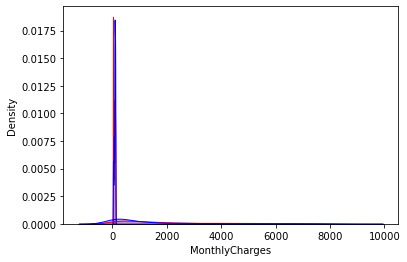

In [11]:
# 4. Visualizing the Data
# KDE plots for MonthlyCharges and TotalCharges
MC = sns.kdeplot(df_new_dummies.MonthlyCharges[(df_new_dummies["Churn"] == 0)], color="Red", shade=True)
MC = sns.kdeplot(df_new_dummies.MonthlyCharges[(df_new_dummies["Churn"] == 1)], ax=MC, color="Blue", shade=True)

TC = sns.kdeplot(df_new_dummies.TotalCharges[(df_new_dummies["Churn"] == 0)], color="Red", shade=True)
TC = sns.kdeplot(df_new_dummies.TotalCharges[(df_new_dummies["Churn"] == 1)], ax=TC, color="Blue", shade=True)

In [12]:
# 5. Train-test split
x = df_new_dummies.drop('Churn', axis=1)
y = df_new_dummies['Churn']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# 6. Model Building and Cross-Validation
# Decision Tree with Cross-Validation and Hyperparameter Tuning
dtmodel = DecisionTreeClassifier(random_state=50)
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
grid_dt = GridSearchCV(dtmodel, param_grid, cv=5, scoring='accuracy')
grid_dt.fit(x_train, y_train)

dt_best_model = grid_dt.best_estimator_
dt_pred = dt_best_model.predict(x_test)

In [14]:
# Evaluation of Decision Tree
print("Best Parameters for Decision Tree:", grid_dt.best_params_)
print(metrics.classification_report(y_test, dt_pred))
dt_accuracy = round(metrics.accuracy_score(y_test, dt_pred) * 100, 2)
print("Decision Tree Accuracy:", dt_accuracy)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1033
           1       0.53      0.46      0.49       374

    accuracy                           0.75      1407
   macro avg       0.67      0.66      0.66      1407
weighted avg       0.74      0.75      0.74      1407

Decision Tree Accuracy: 74.91


In [15]:
# Feature Engineering: PCA for dimensionality reduction
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


In [16]:
# Random Forest with Hyperparameter Tuning
rfmodel = RandomForestClassifier(random_state=0)
param_grid_rf = {'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rfmodel, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(x_train_pca, y_train)

rf_best_model = grid_rf.best_estimator_
rf_pred = rf_best_model.predict(x_test_pca)

In [17]:
# Evaluation of Random Forest
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print(metrics.classification_report(y_test, rf_pred))
rf_accuracy = round(metrics.accuracy_score(y_test, rf_pred) * 100, 2)
print("Random Forest Accuracy:", rf_accuracy)

Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1033
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest Accuracy: 79.18


In [18]:
# Logistic Regression with Cross-Validation
logmodel = LogisticRegression(random_state=50, max_iter=500)
logmodel.fit(x_train_pca, y_train)

log_pred = logmodel.predict(x_test_pca)
log_accuracy = round(metrics.accuracy_score(y_test, log_pred) * 100, 2)
print(metrics.classification_report(y_test, log_pred))
print("Logistic Regression Accuracy:", log_accuracy)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Logistic Regression Accuracy: 78.82


In [19]:
# 7. SMOTEENN with Decision Tree and Random Forest
sm = SMOTEENN()
x_new, y_new = sm.fit_resample(x, y)
xr_train, xr_test, yr_train, yr_test = train_test_split(x_new, y_new, test_size=0.2, random_state=42)

# Decision Tree with SMOTEENN
dtmodel_smote = DecisionTreeClassifier(random_state=50)
dtmodel_smote.fit(xr_train, yr_train)
dt_pred_smote = dtmodel_smote.predict(xr_test)
dt_accuracy_smote = (dtmodel_smote.score(xr_test, yr_test)) * 100

# Random Forest with SMOTEENN
rfmodel_smote = RandomForestClassifier(n_estimators=100, random_state=0)
rfmodel_smote.fit(xr_train, yr_train)
rf_pred_smote = rfmodel_smote.predict(xr_test)
rf_accuracy_smote = (rfmodel_smote.score(xr_test, yr_test)) * 100

# Logistic Regression with SMOTEENN
logmodel_smote = LogisticRegression(random_state=50)
logmodel_smote.fit(xr_train, yr_train)
log_pred_smote = logmodel_smote.predict(xr_test)
log_accuracy_smote = (logmodel_smote.score(xr_test, yr_test)) * 100

C:\Users\prase\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# 8. Error Analysis: Confusion Matrices
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))


Decision Tree Confusion Matrix:
[[882 151]
 [202 172]]
Random Forest Confusion Matrix:
[[940  93]
 [200 174]]


In [21]:
# 9. Model Comparison
Model_Comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression with SMOTEENN', 'Decision Tree', 'Decision Tree with SMOTEENN', 'Random Forest', 'Random Forest with SMOTEENN'],
    'Score': [log_accuracy, log_accuracy_smote, dt_accuracy, dt_accuracy_smote, rf_accuracy, rf_accuracy_smote]})

Model_Comparison_df = Model_Comparison.sort_values(by='Score', ascending=False)
print(Model_Comparison_df)

                               Model      Score
5        Random Forest with SMOTEENN  95.311168
1  Logistic Regression with SMOTEENN  93.265132
3        Decision Tree with SMOTEENN  93.009378
4                      Random Forest  79.180000
0                Logistic Regression  78.820000
2                      Decision Tree  74.910000


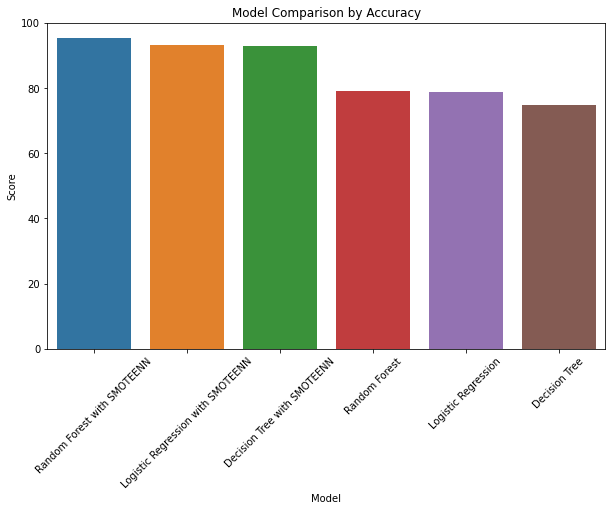

In [22]:
# 10. Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', data=Model_Comparison_df)
plt.title("Model Comparison by Accuracy")
plt.xticks(rotation=45)
plt.show()
